
# ***User_features***






In [1]:
import pandas as pd
# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
pd.set_option('display.max_rows', None)

In [2]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import os
from pathlib import Path




In [3]:
#from google.colab import auth
#auth.authenticate_user()
#from google.cloud import bigquery
#from pandas_gbq import read_gbq


#project_id = "data-analytics-bootcamp-363212"

#query = '''
#SELECT *
#FROM `data-analytics-bootcamp-363212.neo_bank.transactions`
#'''

#df_transactions = read_gbq(query, project_id=project_id)

In [4]:
#os.makedirs("/content/drive/MyDrive/Documents", exist_ok=True)

#df_transactions.to_csv(
 #   "/content/drive/MyDrive/Documents/eval_transactions.csv",
  #  index=False)

#print("Saved to Google Drive Documents folder")

In [5]:
#df_transactions.to_csv("eval_transactions.csv", index=False)

#from google.colab import files
#files.download("eval_transactions.csv")

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
df_transactions = pd.read_csv(
    "eval_transactions.csv"
)

df_transactions.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_505,TOPUP,AED,298.62,COMPLETED,NaN,NaN,NaN,NaN,INBOUND,user_4773,2018-08-02 09:41:07.426363+00:00
1,transaction_1755379,EXCHANGE,AED,3.51,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_10435,2018-09-06 10:23:15.807148+00:00
2,transaction_1667,EXCHANGE,AED,0.05,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_397,2018-05-16 06:09:28.063037+00:00
3,transaction_1429,EXCHANGE,AED,24.14,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_4399,2018-12-19 20:22:03.550130+00:00
4,transaction_345,EXCHANGE,AED,0.21,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1731,2018-10-27 13:29:56.524826+00:00


In [8]:
df_transactions.columns = df_transactions.columns.str.lower().str.replace(" ", "_")
text_cols = df_transactions.select_dtypes(include='object').columns

for col in text_cols:
    df_transactions[col] = (df_transactions[col].str.lower() .str.strip().str.replace(r'\s+', '_', regex=True) .str.replace(r'[^\w]', '', regex=True))

In [9]:
df_transactions["ea_merchant_city"] = (
    df_transactions["ea_merchant_city"]
    # 1) fake NaNs
    .replace(
        ["nan", "Nan", "NAN", "none", "None", "null", "NULL", "", " "],
        pd.NA
    )
    .fillna("Not Applicable")
    # 2) cleaning
    .astype(str)
    .str.lower()
    .str.replace(r'\b\d{2}-\d{3}\b', '', regex=True)
    .str.replace(r'[_\d]+', ' ', regex=True)
    .str.replace(r'^\s*-+', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .str.title()
    # 3) numeric-only OR empty after cleaning → Not Applicable
    .replace(r'^\d+$', "Not Applicable", regex=True)
    .replace(r'^$', "Not Applicable", regex=True)
)


In [10]:
!pip install pycountry

In [11]:
import pycountry

def alpha3_to_alpha2(code):
    try:
        return pycountry.countries.get(alpha_3=code).alpha_2
    except:
        return None

df_transactions["merchant_country"] = (
    df_transactions["ea_merchant_country"]
    .apply(alpha3_to_alpha2)
)

In [12]:
df_transactions['ea_merchant_country']=df_transactions["ea_merchant_country"].str.upper()

In [13]:
df_transactions["ea_merchant_city"] = df_transactions["ea_merchant_city"].fillna("Not Applicable")
df_transactions["merchant_country"] = df_transactions["merchant_country"].fillna("Not Applicable")
df_transactions["ea_merchant_country"] = df_transactions["ea_merchant_country"].fillna("Not Applicable")
df_transactions["ea_cardholderpresence"] = df_transactions["ea_cardholderpresence"].fillna("Not Applicable")

In [14]:
df_transactions["ea_merchant_mcc"] = df_transactions["ea_merchant_mcc"].fillna(-1)

In [15]:
df_transactions['created_date'] = (
    df_transactions['created_date']
    .astype(str)
    .str.extract(r'(\d{8}_\d{6})')[0]
)

df_transactions['created_date'] = pd.to_datetime(
    df_transactions['created_date'],
    format='%Y%m%d_%H%M%S',
    errors='coerce'
)

In [16]:
df_completed = df_transactions[
    df_transactions['transactions_state'] == 'completed'
]
user_features = df_completed.groupby('user_id').agg(
    total_completed_transactions=('amount_usd', 'sum'),
    number_completed_transactions=('transaction_id', 'count'),
    avg_completed_transaction_amount=('amount_usd','mean'),
    last_completed_transaction_date=('created_date','max')
).reset_index()

In [17]:
reference_date = df_completed['created_date'].max()

In [18]:
user_features['Recency(days_since_last_completed_transaction)'] = (
    reference_date - user_features['last_completed_transaction_date']
).dt.days

In [19]:
user_activity_span = df_transactions.groupby('user_id')['created_date'].agg(['min','max']).reset_index()

user_activity_span['activity_days'] = (
    user_activity_span['max'] - user_activity_span['min']
).dt.days + 1

In [20]:
user_features = user_features.merge(
    user_activity_span[['user_id','activity_days']],
    on='user_id',
    how='left'
)

In [21]:
user_features['Engagement Intensity(transaction_frequency)'] = (
    user_features['number_completed_transactions'] /
    user_features['activity_days']
)

In [22]:
user_features['churn_flag']=(user_features['Recency(days_since_last_completed_transaction)']>30).astype(int)

In [23]:
user_features['Transaction reliability(success_rate)'] = (
    user_features['number_completed_transactions'] /
    user_features['user_id'].map(
        df_transactions.groupby('user_id')['transaction_id'].count()
    )
)

In [24]:
user_features.head()

,user_id,total_completed_transactions,number_completed_transactions,avg_completed_transaction_amount,last_completed_transaction_date,Recency(days_since_last_completed_transaction),activity_days,Engagement Intensity(transaction_frequency),churn_flag,Transaction reliability(success_rate)
0,user_0,12648.60,350,36.138857,2019-05-02 03:38:44,13,471,0.743100,0,0.899743
1,user_1,5705.35,114,50.046930,2019-02-24 21:25:15,79,392,0.290816,1,0.883721
2,user_10,24508.38,846,28.969716,2019-05-11 11:01:00,4,493,1.716024,0,0.803419
3,user_100,16106.18,110,146.419818,2019-05-07 13:00:24,8,477,0.230608,0,0.827068
4,user_1000,20128.31,35,575.094571,2018-06-26 05:00:42,323,171,0.204678,1,0.897436


In [25]:
user_features['churn_flag'].value_counts(normalize=True)

,proportion
churn_flag,
0,0.581791
1,0.418209


In [26]:
comparison = user_features.groupby('churn_flag')[[
    'total_completed_transactions',
    'number_completed_transactions',
    'avg_completed_transaction_amount',
    'Recency(days_since_last_completed_transaction)',
    'activity_days',
    'Engagement Intensity(transaction_frequency)',
    'Transaction reliability(success_rate)'
]].agg(['mean', 'median', 'std'])

comparison

total_completed_transactions                          \
                                   mean    median           std   
churn_flag                                                        
0                          12519.028530  4383.105  54085.298111   
1                           2610.010239   519.440   8792.071799   

           number_completed_transactions                     \
                                    mean median         std   
churn_flag                                                    
0                             196.877551  103.0  274.481918   
1                              36.859982   13.0   68.527793   

           avg_completed_transaction_amount                         \
                                       mean     median         std   
churn_flag                                                           
0                                 96.800130  35.945268  723.325907   
1                                 79.434277  28.388235  374.392818   

           Recency(days_since_last_completed_transaction)                     \
                                                     mean median         std   
churn_flag                                                                     
0                                               10.211132    8.0    6.830767   
1                                              159.469738  132.0  111.724000   

           activity_days                     \
                    mean median         std   
churn_flag                                    
0             270.416976  261.0  108.337644   
1             144.762937  120.0  125.350316   

           Engagement Intensity(transaction_frequency)                      \
                                                  mean    median       std   
churn_flag                                                                   
0                                             0.737045  0.409818  0.958321   
1                                             0.511212  0.222222  0.759877   

           Transaction reliability(success_rate)                      
                                            mean    median       std  
churn_flag                                                            
0                                       0.841288  0.875706  0.125282  
1                                       0.728387  0.777778  0.203574

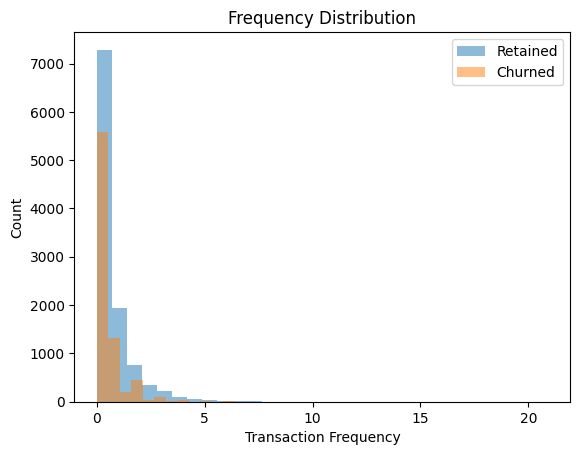

In [27]:
plt.hist(
    user_features[user_features['churn_flag']==0]['Engagement Intensity(transaction_frequency)'],
    alpha=0.5,
    label='Retained',
    bins=30
)

plt.hist(
    user_features[user_features['churn_flag']==1]['Engagement Intensity(transaction_frequency)'],
    alpha=0.5,
    label='Churned',
    bins=30
)

plt.legend()
plt.title("Frequency Distribution")
plt.xlabel("Transaction Frequency")
plt.ylabel("Count")
plt.show()

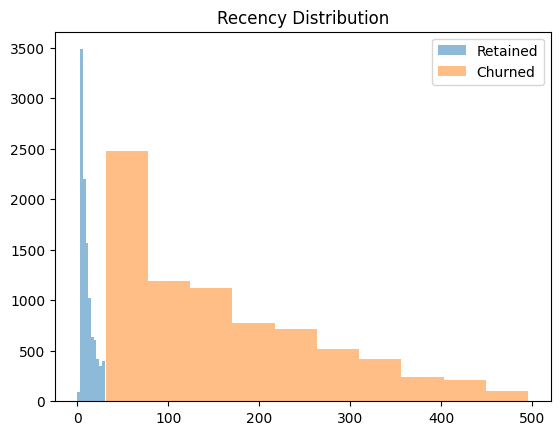

In [28]:
import matplotlib.pyplot as plt

plt.hist(user_features[user_features['churn_flag']==0]['Recency(days_since_last_completed_transaction)'], alpha=0.5, label='Retained')
plt.hist(user_features[user_features['churn_flag']==1]['Recency(days_since_last_completed_transaction)'], alpha=0.5, label='Churned')
plt.legend()
plt.title("Recency Distribution")
plt.show()

# **Statistical Significance**

Engagement Intensity(transaction_frequency)

In [29]:
#Engagement Intensity(transaction_frequency)
from scipy.stats import ttest_ind

retained = user_features[user_features['churn_flag']==0]
churned = user_features[user_features['churn_flag']==1]

t_stat, p_value = ttest_ind(
    retained['Engagement Intensity(transaction_frequency)'],
    churned['Engagement Intensity(transaction_frequency)'],
    equal_var=False
)

print("p-value:", p_value)

p-value: 8.049402390322957e-71


In [30]:
#Effect Size
import numpy as np

mean_diff = retained['Engagement Intensity(transaction_frequency)'].mean() - churned['Engagement Intensity(transaction_frequency)'].mean()
print("Mean difference:", mean_diff)

Mean difference: 0.2258323225674712


In [31]:
#Behavioral Pattern Extraction
low_freq_churn = (
    churned['Engagement Intensity(transaction_frequency)'] <
    user_features['Engagement Intensity(transaction_frequency)'].quantile(0.25)
).mean()
print("Percent of churned users with low frequency rate:", low_freq_churn)

Percent of churned users with low frequency rate: 0.3615950445218738


total_completed_transactions

In [32]:
#total_completed_transactions
from scipy.stats import ttest_ind

retained = user_features[user_features['churn_flag']==0]
churned = user_features[user_features['churn_flag']==1]

t_stat, p_value = ttest_ind(
    retained['total_completed_transactions'],
    churned['total_completed_transactions'],
    equal_var=False
)

print("p-value:", p_value)

p-value: 9.321578421362498e-77


In [33]:
#Effect Size
import numpy as np

mean_diff = retained['total_completed_transactions'].mean() - churned['total_completed_transactions'].mean()
print("Mean difference:", mean_diff)

Mean difference: 9909.01829094412


In [34]:
#Behavioral Pattern Extraction
threshold = user_features['total_completed_transactions'].quantile(0.25)

low_value_churn = (
    churned['total_completed_transactions'] < threshold
).mean()

print("Percent of churned users with low monetary value:", low_value_churn)

Percent of churned users with low monetary value: 0.465866563427539


Transaction reliability(success_rate)

In [35]:
#Transaction reliability(success_rate)
from scipy.stats import ttest_ind

retained = user_features[user_features['churn_flag']==0]
churned = user_features[user_features['churn_flag']==1]

t_stat, p_value = ttest_ind(
    retained['Transaction reliability(success_rate)'],
    churned['Transaction reliability(success_rate)'],
    equal_var=False
)

print("p-value:", p_value)

p-value: 0.0


In [36]:
#Effect Size
import numpy as np

mean_diff = retained['Transaction reliability(success_rate)'].mean() - churned['Transaction reliability(success_rate)'].mean()
print("Mean difference:", mean_diff)

Mean difference: 0.1129011137447482


In [37]:
#Behavioral Pattern Extraction
low_success_churn = (
    churned['Transaction reliability(success_rate)'] < 0.8
).mean()

print("Percent of churned users with low success rate:", low_success_churn)

Percent of churned users with low success rate: 0.5334881920247774


In [39]:
user_features.to_csv("user_features.csv",index=False,encoding="utf-8")

from google.colab import files
files.download("user_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>